# Using TensorFlow Elastic Distributed Training in Watson Machine Learning Accelerator Notebook
In this sample, you will learn how to accelerate your TensorFlow training using Elastic Distributed Training in Watson Machine Learning Accelerator Notebook. The kernel will start with GPU library imported but no GPU resource requested. GPU allocation to the current kernel only happens when you explicitly call Elastic Distributed Training train api in Notebook with requested maximum number, and 1 to the maximum number of GPUs will be allocated dynamically during the train execution. Here we use the MNIST dataset, a series of images of numbers, and train the model to better recognize hand written numbers.

## Environment variables
The following environment variables can be used in the Notebook. These variables specify the data source, the training directory, and directory for the trained model.

In [1]:
import os

DATA_DIR = os.getenv("DATA_DIR", "/gpfs/mydatafs")
print("DATA_DIR: " + DATA_DIR)

DATA_DIR: /gpfs/mydatafs


## Define the dataset and sample model
The following section, defines and loads the dataset and the model.

In [2]:
from __future__ import print_function

import tensorflow as tf
from pyedt.fabric_model import FabricModel

num_classes = 10
# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)


def get_dataset():
    print ("In mnist_cnn get_dataset")
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
    test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
    return(train_datagen.flow(x_train, y_train, batch_size=batch_size),
           test_datagen.flow(x_test,  y_test,  batch_size=batch_size))

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))



2023-10-31 06:12:27,966 233 INFO __init__.<module> - Using keras backend.


If you want to use 'pytorch' or 'tensorflow', restart kernel and export FABRIC_BACKEND before importing fabric_model modules.
11490434/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


## Submit the Elastic Distributed Training Job

In [3]:
# Batch size for each iteration.
batch_size = 64
# The number of epochs to run.
epochs = 2

import math
print("total iterations: {}".format(math.ceil(x_train.shape[0]/batch_size)*epochs))

total iterations: 1876



--------END TRAINING: completed 938 iterations in 361.5641040802002 seconds.--------
Waiting the job to stop...


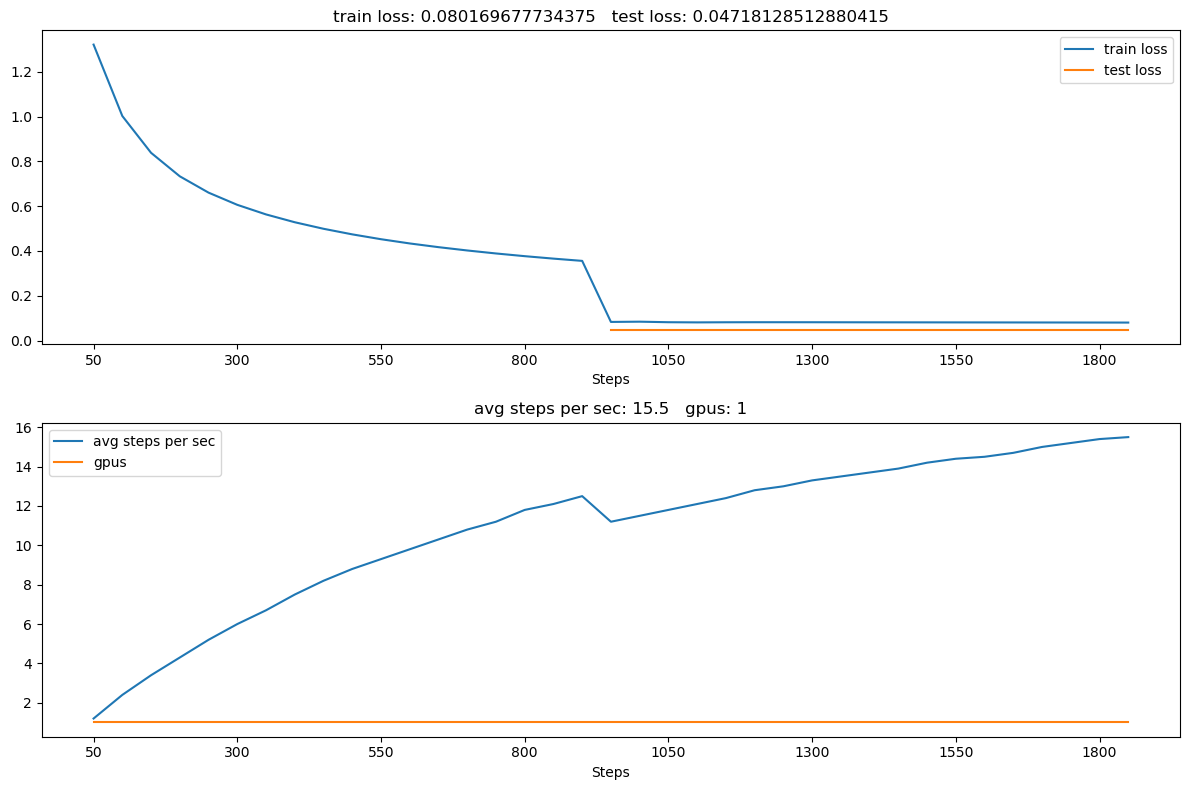

Job wmla-bjyuanxz-notebook-1698732758980 finishes with state FINISHED.
driver service subprocess 282 stopped


In [4]:
# Maximum number of GPUs to be requested. 
# If the maximum number of GPUs is set to 6, the number of GPUs that are 
# allocated dynamically during training execution is between 1 and 6 GPUs.
max_num_workers = 1

edt_m = FabricModel(model,
                    get_dataset,
                    loss_function="categorical_crossentropy",
                    optimizer=tf.keras.optimizers.Adam())
# TensorFlow requires higher memory allocation compared to PyTorch. 
# Manually set driver and worker memory settings for optimal performance. 
edt_m.train(epochs, batch_size, max_num_workers, worker_memory='16G', driver_memory="1G")

## View the training result
After training is completed, view the saved trained model.

In [5]:
edt_m.download()

Save model:  /tmp/wmla-bjyuanxz-notebook-1698732758980.zip


Use `out_dir` argument to download to a customized directory.

In [6]:
out_dir = '/tmp/out'
edt_m.download(out_dir=out_dir)

Save model:  /tmp/out/wmla-bjyuanxz-notebook-1698732758980.zip
